<a href="https://colab.research.google.com/github/suzzini/DS_Project/blob/main/Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
INPUT_DIR='drive/MyDrive/dataset/section4_p'
!ls {INPUT_DIR}

 anime.csv	 anime_with_synopsis.csv   rating_complete.csv
 animelist.csv	'html folder'		   watching_status.csv


In [5]:
import numpy as np
import pandas as pd

rating_df = pd.read_csv(INPUT_DIR + '/animelist.csv', 
                        usecols=["user_id", "anime_id", "rating"]
                        )
rating_df.head(4)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0


In [6]:
# user 별로 몇개의 애니메이션을 rating 했는지 확인
n_ratings = rating_df['user_id'].value_counts()
n_ratings.describe()

count    325770.000000
mean        335.281785
std         425.411070
min           1.000000
25%          96.000000
50%         224.000000
75%         436.000000
max       17546.000000
Name: user_id, dtype: float64

In [7]:
# 400개 이상의 rate를 준 유저만 사용
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
len(rating_df)

71418114

In [8]:
# rating 0~1로 정규화(?) 해주기
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
print(min_rating, max_rating)

0 10


In [9]:
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])
print('Avg', AvgRating)

Avg 0.40477935891013467


In [10]:
# 중복행이 있는지 확인하고 제거
duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating_df = rating_df[~duplicates]

print('> {} duplicates'.format(rating_df.duplicated().sum()))

> 1 duplicates
> 0 duplicates


### user와 animation 0부터 매핑해주기

In [11]:
# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist() 
user2user_encoded = {x: i for i, x in enumerate(user_ids)} # {2:0, 6:1, 12:2, 16:3, ...}
user_encoded2user = {i: x for i, x in enumerate(user_ids)} # {0:2, 1:6, 2:12, 3:16, ...}

rating_df["user"] = rating_df["user_id"].map(user2user_encoded) #user를 0부터 새로운 인덱스로 mapping
n_users = len(user2user_encoded)

In [12]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)} # {24833:0, 235:1, 36721:2, 40956:3, ...}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 91641, Num of animes: 17560
Min rating: 0.0, Max rating: 1.0


In [13]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


### 평가를 400개 이상인 유저들만 추출한 후, 각 유저 별, 애니메이션을 0부터 매핑완료(바꾼 것이 아님 !!)

- user 수 : 91641 (0~91640)
- animation 수 : 17560 (0~17559)

**DataFrame.sample(n,frac,replace,weights,random_state,axis)**

: dataframe에서 무작위 표본 추출하기

- n : 추출할 표본 개수
- frac : 추출할 표본 비율(n 또는 frac 하나만 사용)
- replace : 복원 추출 여부(true or false)
- weights : 가중치 여부(컬럼 이름)
- random_state : 난수 발생 초기값
- axis : 0(인덱스 기준), 1(컬럼 기준)

In [14]:
# Shuffle
rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

In [15]:
# Split
test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size #71418113-10000

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 71408113
> Test set ratings: 10000


In [16]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [17]:
X_train_array
#유저 index
#애니메이션 index

[array([23948, 72463, 62985, ..., 34207, 58411, 58969]),
 array([11200,   757,  1808, ...,  3456,  3235,  2428])]

In [18]:
# Accelerator check
import tensorflow as tf

TPU_INIT = True

if TPU_INIT:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    !nvidia-smi
    
print(tf.__version__)

INFO:tensorflow:Initializing the TPU system: grpc://10.65.118.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.65.118.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


2.5.0


In [19]:
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam

- embedding
  - input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
  - output_dim: Integer. Dimension of the dense embedding.
  - Input shape : 2D tensor with shape: (batch_size, input_length).
  - Output shape : 3D tensor with shape: (batch_size, input_length, output_dim).

- input shape
  - 여기서 shape = (1,) 엄밀히 말하면 vector가 한개라는 뜻이됩니다. 데이터 shape이 (5,1)일 경우 5행1열을 가진 데이터라는 뜻이 되는데요. 여기서 행은 무시하고 열!만 shape으로 입력을 해주는 것 입니다. 데이터는 계속 추가 될 수 있으므로 열(feature)만 중요

In [20]:
# Embedding layers
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

#Num of users: 91641, Num of animes: 17560
def RecommenderNet():
    embedding_size = 128
    
    #user
    user = Input(name = 'user', shape = [1]) # [1]=1=(1,)
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, #91641
                       output_dim = embedding_size)(user)
                       
    #animation
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes, 
                       output_dim = embedding_size)(anime)
    
    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)
        
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model


if TPU_INIT:    
    with tpu_strategy.scope():
        model = RecommenderNet()
else:
    model = RecommenderNet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 128)       11730048    user[0][0]                       
__________________________________________________________________________________________________
anime_embedding (Embedding)     (None, 1, 128)       2247680     anime[0][0]                      
______________________________________________________________________________________________

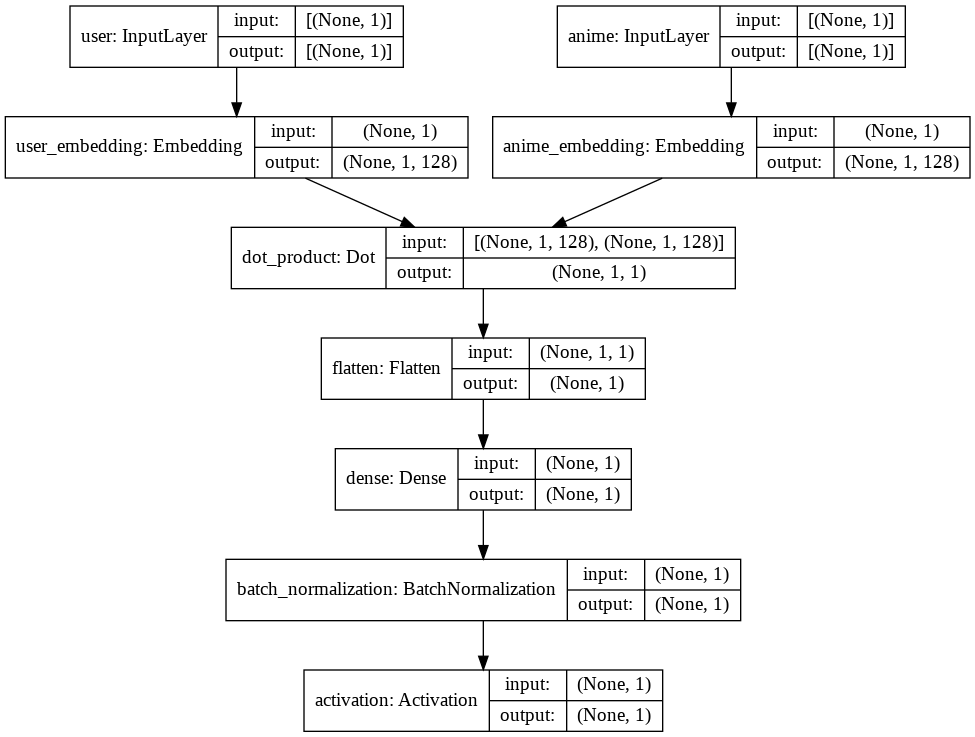

In [21]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='./dot.png',show_shapes=True, show_layer_names=True)

- ModelCheckpoint : 모델이 학습하면서 정의한 조건을 만족했을 때 Model의 weight 값을 중간 저장해 줍니다. 학습시간이 꽤 오래걸린다면, 모델이 개선된 validation score를 도출해낼 때마다 weight를 중간 저장함으로써, 혹시 중간에 memory overflow나 crash가 나더라도 다시 weight를 불러와서 학습을 이어나갈 수 있기 때문에, 시간을 save해 줄 수 있습니다.
- ReduceLROnPlateau : 학습이 진행되지 않는 안정기에 들어서면, learning rate에 변화를 줍니다. 
- EarlyStopping : model의 성능 지표가 설정한 epoch동안 개선되지 않을 때 조기 종료할 수 있습니다. EarlyStopping과 이전에 언급한 ModelCheckpoint 콜백의 조합을 통하여, 개선되지 않는 학습에 대한 조기 종료를 실행하고, ModelCheckpoint로 부터 가장 best model을 다시 로드하여 학습을 재게할 수 있습니다.
- LearningRateScheduler : epoch에 따라 학습률을 조정하는 callback

In [22]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,   
]

In [23]:
# Model training
#con
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
893/893 [==============================] - 56s 32ms/step - loss: 0.8036 - mae: 0.3848 - mse: 0.2000 - val_loss: 0.8004 - val_mae: 0.3868 - val_mse: 0.2008
Epoch 2/20
893/893 [==============================] - 23s 26ms/step - loss: 0.7910 - mae: 0.3810 - mse: 0.1953 - val_loss: 0.7131 - val_mae: 0.3479 - val_mse: 0.1648
Epoch 3/20
893/893 [==============================] - 23s 26ms/step - loss: 0.6303 - mae: 0.3019 - mse: 0.1274 - val_loss: 0.5728 - val_mae: 0.2705 - val_mse: 0.1043
Epoch 4/20
893/893 [==============================] - 23s 26ms/step - loss: 0.5547 - mae: 0.2570 - mse: 0.0948 - val_loss: 0.5408 - val_mae: 0.2504 - val_mse: 0.0909
Epoch 5/20
893/893 [==============================] - 23s 25ms/step - loss: 0.5244 - mae: 0.2356 - mse: 0.0827 - val_loss: 0.5142 - val_mae: 0.2291 - val_mse: 0.0808
Epoch 6/20
893/893 [==============================] - 23s 26ms/step - loss: 0.4972 - mae: 0.2133 - mse: 0.0728 - val_loss: 0.4961 - val_mae: 0.2110 - val_mse: 0.0747
Epoc

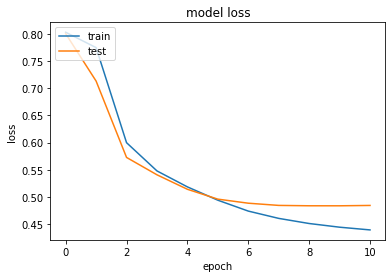

In [24]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [25]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights


anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

get_weights() : 훈련 중 업데이트 되고 있는 가중치 값 확인 가능한 함수

In [26]:
model.get_layer('anime_embedding').get_weights()[0]

array([[-0.00177166,  0.02395603,  0.05273693, ..., -0.03700701,
         0.01154113,  0.00248692],
       [ 0.0379828 , -0.03663992,  0.02991057, ...,  0.03083038,
         0.04977988,  0.00950897],
       [-0.02688539, -0.03002168, -0.00188577, ..., -0.05289179,
         0.02969799, -0.00987447],
       ...,
       [-0.02620983, -0.04064313, -0.03151239, ...,  0.01993116,
        -0.01630796,  0.01705273],
       [-0.02418925,  0.00261804,  0.02566509, ...,  0.01683071,
         0.03277872, -0.02233203],
       [-0.03679195, -0.04049143,  0.01811455, ..., -0.00618189,
        -0.05036659, -0.02228029]], dtype=float32)

In [27]:
df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df = df.replace("Unknown", np.nan)

In [28]:
df.head()

,MAL_ID,Name,Score,Genders,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",NaN,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [29]:
# Fixing Names
def getAnimeName(anime_id):
    try: #eng_version 또는 Name의 값으로 return
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')
    
    return name

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df.sort_values(by=['Score'], 
               inplace=True,
               ascending=False, 
               kind='quicksort',
               na_position='last')

df = df[["anime_id", "eng_version", 
         "Score", "Genders", "Episodes", 
         "Type", "Premiered", "Members"]]

In [30]:
df.head()

,anime_id,eng_version,Score,Genders,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [31]:
def getAnimeFrame(anime):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [32]:
print(getAnimeFrame('Fullmetal Alchemist:Brotherhood'))
getAnimeFrame(5114)

      anime_id                      eng_version  ...    Premiered  Members
3971      5114  Fullmetal Alchemist:Brotherhood  ...  Spring 2009  2248456

[1 rows x 8 columns]


,anime_id,eng_version,Score,Genders,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


In [33]:
cols = ["MAL_ID", "Name", "Genders", "sypnopsis"]
sypnopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', usecols=cols)

def getSypnopsis(anime):
    if isinstance(anime, int):
        return sypnopsis_df[sypnopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return sypnopsis_df[sypnopsis_df.Name == anime].sypnopsis.values[0]

In [34]:
sypnopsis_df.head()

,MAL_ID,Name,Genders,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [35]:
pd.set_option("max_colwidth", None)

def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights #anime_weights=extract_weights('anime_embedding', model)
      
        dists = np.dot(weights, weights[encoded_index]) #모든 애니메이션의 임베팅 벡터와 구하고자 하는 애니메이션의 임베팅 벡터와 내적연산하여 유사성을 계산
        sorted_dists = np.argsort(dists) #연관도 순서별로 인덱스를 저장
        #[0.3 0.7 0.02] => [2 0 1]
       

        #자기 자신과는 1이 유사도로 나오므로 +1 해줘야 원하는 개수를 구할 수 있음
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        rindex = df
        
        #print(closest)
        SimilarityArr = []

        #유사하게 나온 애니메이션들의 정보 출력
        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            sypnopsis = getSypnopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id)
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genders.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity,"genre": genre,
                                  'sypnopsis': sypnopsis})
        #print(len(SimilarityArr))
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[1:n] #자기 자신을 제외하고 return 
        #return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

In [36]:
find_similar_animes('Howl\'s Moving Castle', n=5, neg=False)

animes closest to Howl's Moving Castle


,anime_id,name,similarity,genre,sypnopsis
4,199,Spirited Away,0.953930,"Adventure, Supernatural, Drama","Stubborn, spoiled, and naïve, 10-year-old Chihiro Ogino is less than pleased when she and her parents discover an abandoned amusement park on the way to their new house. Cautiously venturing inside, she realizes that there is more to this place than meets the eye, as strange things begin to happen once dusk falls. Ghostly apparitions and food that turns her parents into pigs are just the start—Chihiro has unwittingly crossed over into the spirit world. Now trapped, she must summon the courage to live and work amongst spirits, with the help of the enigmatic Haku and the cast of unique characters she meets along the way. Vivid and intriguing, Sen to Chihiro no Kamikakushi tells the story of Chihiro's journey through an unfamiliar world as she strives to save her parents and return home."
3,523,My Neighbor Totoro,0.922831,"Adventure, Comedy, Supernatural","In 1950s Japan, Tatsuo Kusakabe relocates himself and his two daughters, Satsuki and Mei, to the countryside to be closer to their mother, who is hospitalized due to long-term illness. As the girls grow acquainted with rural life, Mei encounters a small, bunny-like creature in the yard one day. Chasing it into the forest, she finds ""Totoro""—a giant, mystical forest spirit whom she soon befriends. Before long, Satsuki too meets Totoro, and the two girls suddenly find their lives filled with magical adventures in nature and fantastical creatures of the woods."
2,164,Princess Mononoke,0.909775,"Action, Adventure, Fantasy","hen an Emishi village is attacked by a fierce demon boar, the young prince Ashitaka puts his life at stake to defend his tribe. With its dying breath, the beast curses the prince's arm, granting him demonic powers while gradually siphoning his life away. Instructed by the village elders to travel westward for a cure, Ashitaka arrives at Tatara, the Iron Town, where he finds himself embroiled in a fierce conflict: Lady Eboshi of Tatara, promoting constant deforestation, stands against Princess San and the sacred spirits of the forest, who are furious at the destruction brought by the humans. As the opposing forces of nature and mankind begin to clash in a desperate struggle for survival, Ashitaka attempts to seek harmony between the two, all the while battling the latent demon inside of him. Princess Mononoke is a tale depicting the connection of technology and nature, while showing the path to harmony that could be achieved by mutual acceptance."
1,512,Kiki's Delivery Service,0.876808,"Adventure, Comedy, Drama, Magic, Romance, Fantasy","Kiki, a 13-year-old witch-in-training, must spend a year living on her own in a distant town in order to become a full-fledged witch. Leaving her family and friends, Kiki undertakes this tradition when she flies out into the open world atop her broomstick with her black cat Jiji. As she settles down in the coastal town of Koriko, Kiki struggles to adapt and ends up wandering the streets with no place to stay—until she encounters Osono, who offers Kiki boarding in exchange for making deliveries for her small bakery. Before long, Kiki decides to open her own courier service by broomstick, beginning her journey to independence. In attempting to find her place among the townsfolk, Kiki brings with her exciting new experiences and comes to understand the true meaning of responsibility."
0,513,Castle in the Sky,0.867269,"Adventure, Fantasy, Romance, Sci-Fi","In a world filled with planes and airships, Sheeta is a young girl who has been kidnapped by government agents who seek her mysterious crystal amulet. While trapped aboard an airship, she finds herself without hope—that is, until the ship is raided by pirates. Taking advantage of the ensuing confusion, Sheeta manages to flee from her captors. Upon her escape, she meets Pazu, a boy who dreams of reaching the fabled flying castle, Laputa. The two decide to embark on a journey to

### Task 2: Finding Similar Users (User Based Recommendation)

In [37]:
print('> picking up random user')

ratings_per_user = rating_df.groupby('user_id').size()
random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=34).index[0]
print('> user_id:', random_user)

> picking up random user
> user_id: 213192


In [38]:
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        rindex = df
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except:
        print('{}!, Not Found in User list'.format(name))

In [39]:
similar_users = find_similar_users(int(random_user), 
                                   n=5, 
                                   neg=False)

similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

> users similar to #213192


,similar_users,similarity
4,173110,0.589551
3,343465,0.575408
2,205106,0.572851
1,80535,0.569822
0,73522,0.568392


### 유저 선호도

In [40]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, 
                             background_color='white', 
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(10,8)) 
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genres_list = []
        for genres in frame['Genders']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1    
        if plot:
            showWordCloud(all_genres)
        
        return genres_list

    
def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75) #상위 75%의 ranking 저장
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile] # 그 이상의 rating 을 갖는 애니메이션만 추출
    top_animes_user = ( #상위 애니메이션 index 저장
        animes_watched_by_user.sort_values(by="rating", ascending=False)#.head(10)
        .anime_id.values
    )
    
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genders"]]
    
    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
    
        print('> preferred genres')
    
    if plot:
        getFavGenre(anime_df_rows, plot)
        
    return anime_df_rows#.eng_version.values

> User #213192 has rated 207 movies (avg. rating = 0.8)
> preferred genres


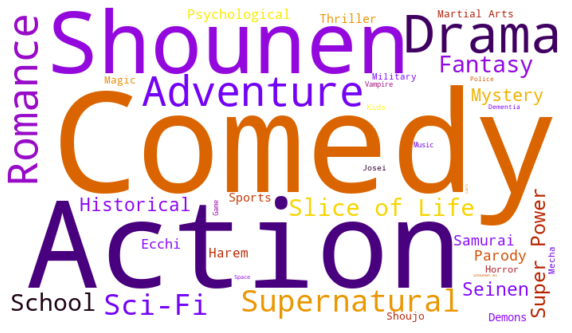

> animes highly rated by this user


,eng_version,Genders
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"


In [41]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(5)

### 유사도가 제일 높은 유저와 장르 선호도 비교(wordcloud)

> User #173110 has rated 326 movies (avg. rating = 0.9)
> preferred genres


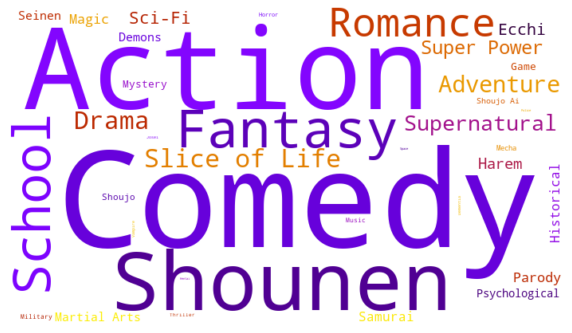

> animes highly rated by this user


,eng_version,Genders
14963,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
12242,Gintama Season 5,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"


In [42]:
first_similar_user=similar_users.iloc[:,0][4]
firstsim_user_pref = get_user_preferences(first_similar_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(firstsim_user_pref).head(5)

### Task 3: Recommending animes for a user

In [49]:
def get_recommended_animes(similar_users, n=10):
    recommended_animes = []
    anime_list = []
    
    #비슷한 유저들이 시청한 애니메이션을 anime_list에 추가(이미 본 애니메이션은 제거)
    for user_id in similar_users.similar_users.values: #유저번호
        pref_list = get_user_preferences(int(user_id), verbose=0) #비슷한 유저a가 시청한 리스트
        pref_list = pref_list[~ pref_list.eng_version.isin(user_pref.eng_version.values)] #user가 시청한 목록은 제거(이미 봤으니 추천해줄 이유 x)
        anime_list.append(pref_list.eng_version.values)
        
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n) #제일 많이 추천된(카운트된) 순으로 정렬
    
    for i, anime_name in enumerate(sorted_list.index):        
        n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
        if isinstance(anime_name, str):
            try:
                frame = getAnimeFrame(anime_name)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genders.values[0]
                sypnopsis = getSypnopsis(int(anime_id))
                recommended_animes.append({"anime_id": anime_id ,
                                            "n": n_user_pref,
                                            "anime_name": anime_name, 
                                            "Genders": genre, 
                                            #"sypnopsis": sypnopsis
                                           })
            except:
                pass
    
    return pd.DataFrame(recommended_animes)

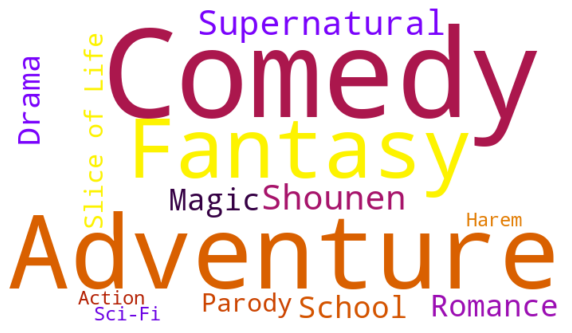


> Top recommendations for user: 213192


,anime_id,n,anime_name,Genders
0,4181,5,Clannad ~After Story~,"Slice of Life, Comedy, Supernatural, Drama, Romance"
1,32937,5,KonoSuba:God's Blessing on This Wonderful World! 2,"Adventure, Comedy, Parody, Supernatural, Magic, Fantasy"
2,37141,5,Cells at Work!,"Comedy, Shounen"
3,18897,5,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen"
4,33489,5,Little Witch Academia,"Adventure, Comedy, Fantasy, Magic, School"
5,2167,5,Clannad,"Comedy, Drama, Romance, School, Slice of Life, Supernatural"
6,35790,5,The Rising of the Shield Hero,"Action, Adventure, Drama, Fantasy"
7,37430,5,That Time I Got Reincarnated as a Slime,"Fantasy, Shounen"
8,38691,4,Dr. Stone,"Sci-Fi, Adventure, Shounen"
9,30831,4,KonoSuba:God's Blessing on This Wonderful World!,"Adventure, Comedy, Fantasy, Magic, Parody, Supernatural"


In [50]:
recommended_animes = get_recommended_animes(similar_users, n=10)
getFavGenre(recommended_animes, plot=True)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes

In [45]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==random_user] #유저a가 시청한 애니메이션 목록
anime_not_watched_df = df[ # 유저a가 시청하지 않은 애니메이션 목록
    ~df["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys())) #교집합 만들기
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]] #input
ratings = model.predict(user_anime_array).flatten() #output

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])
    
    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genders.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue
            
        Results.append({#"anime_id": id_, 
                        "name": name, 
                        "pred_rating": rating,
                        "genre": genre, 
                        #'sypnopsis': sypnopsis
                        })

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)

#test
#test=pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)

Results = pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)
Results

Showing recommendations for user: 213192
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


,name,pred_rating,genre
8,Gintama Season 4,0.975172,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
1,Gintama Season 5,0.974159,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
9,Gintama°: Umai-mono wa Atomawashi ni Suru to Yokodorisareru kara Yappari Saki ni Kue,0.973117,"Action, Comedy, Historical, Parody, Samurai, Shounen"
4,Toshi wo Totta Wani,0.970529,Drama
6,Shu,0.969936,Fantasy
7,Ganso Banana no Tamashii,0.968571,"Music, Kids"
0,Haikyu!! 3rd Season,0.964991,"Comedy, Sports, Drama, School, Shounen"
5,Cat Shit One,0.964272,"Action, Fantasy, Military"
2,Gintama.:Slip Arc,0.963776,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
3,9,0.962953,Music


### 비슷한 유저 5명들로부터 추천받은 애니메이션의 평점 예상하기

In [61]:
print("---" * 25)
print("> [User A] anime recommendations by similiar users")
print("---" * 25)

Results

---------------------------------------------------------------------------
> [User A] anime recommendations by similiar users
---------------------------------------------------------------------------


,name,pred_rating,genre
4,Little Witch Academia,0.891341,"Adventure, Comedy, Fantasy, Magic, School"
7,Clannad ~After Story~,0.839662,"Slice of Life, Comedy, Supernatural, Drama, Romance"
5,Nisekoi:False Love,0.823993,"Harem, Comedy, Romance, School, Shounen"
1,KonoSuba:God's Blessing on This Wonderful World! 2,0.821986,"Adventure, Comedy, Parody, Supernatural, Magic, Fantasy"
8,Clannad,0.816105,"Comedy, Drama, Romance, School, Slice of Life, Supernatural"
3,KonoSuba:God's Blessing on This Wonderful World!,0.802389,"Adventure, Comedy, Fantasy, Magic, Parody, Supernatural"
6,Cells at Work!,0.777290,"Comedy, Shounen"
9,That Time I Got Reincarnated as a Slime,0.761682,"Fantasy, Shounen"
0,Dr. Stone,0.647472,"Sci-Fi, Adventure, Shounen"
2,The Rising of the Shield Hero,0.614547,"Action, Adventure, Drama, Fantasy"
